# Inicializar

In [1]:
from Modelos.base_model import base_model
from Modelos.serie_model import serie_model
from Modelos.parallel_model import parallel_model
from Modelos.hybrid_model import hybrid_model
from utils.utils import mostrarResultadosTabla, generate_equidistant_list, graficar_costos_minimizados

In [2]:
totalNodes = 10
linkCost = 10
costByNodeType = {0: 5, 1: 12, 2: 20}
reliabilityByNodeType = {0: 0.6, 1: 0.7, 2: 0.8}
baseModel = base_model(totalNodes, costByNodeType)

Restricted license - for non-production use only - expires 2026-11-23


# Pruebas

## Serie

In [3]:
# Obtener la confiabilidad mínima y máxima obtenibles para el modelo serie
# Hacer una lista de confiabilidades equidistantes entre la mínima y máxima
seriesMinReliability = reliabilityByNodeType[0] ** totalNodes
seriesMaxReliability = reliabilityByNodeType[2] ** totalNodes
seriesRequiredReliabilities = generate_equidistant_list(seriesMinReliability, seriesMaxReliability, 10)
print(seriesMinReliability, seriesMaxReliability)
print(seriesRequiredReliabilities)

0.006046617599999997 0.10737418240000006
[0.0152582144, 0.0244698112, 0.033681408, 0.0428930048, 0.0521046016, 0.0613161984, 0.0705277952, 0.079739392, 0.0889509888, 0.0981625856]


In [4]:
# Crear y optimizar el modelo en serie
try:
    seriesMinCost, seriesVars, seriesModel = serie_model(baseModel, totalNodes, linkCost, reliabilityByNodeType, seriesRequiredReliabilities[5])
    mostrarResultadosTabla(totalNodes, seriesMinCost, seriesVars)

except Exception as e:
    print(f"Error: {e}")

Cantidad de Nodos: 10
Resultado de la Optimización:
Costo Total: 258.0
Costo nodos: 168.0
Costo enlaces: 90.0
Nodos activos (x):
    Low Cost  Mid Cost  High Cost
1          0         1          0
2          0         1          0
3          0         1          0
4          0         0          1
5          0         0          1
6          0         0          1
7          0         1          0
8          0         0          1
9          0         0          1
10         0         0          1


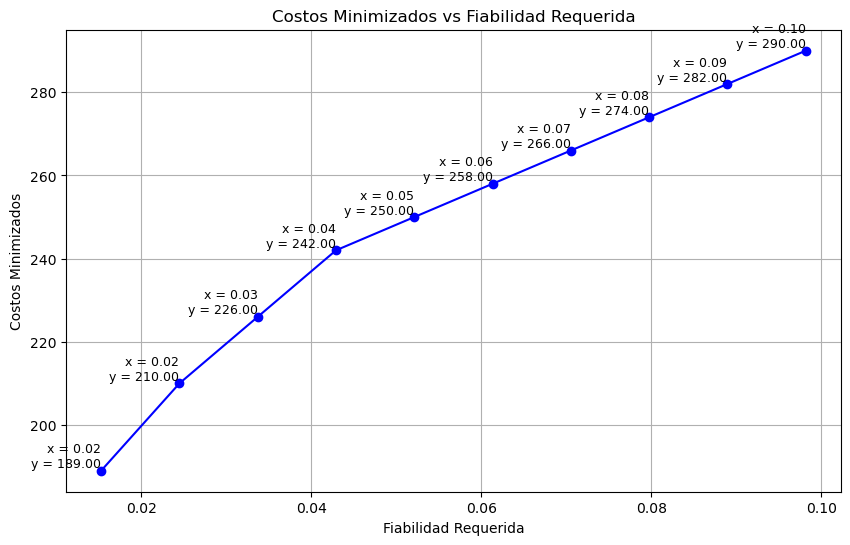

In [5]:
# Graficar los costos minimizados para cada confiabilidad requerida
try:
    serieMinimizedCosts = []
    for reqReliability in seriesRequiredReliabilities:
        minCost, seriesVars, seriesModel = serie_model(baseModel, totalNodes, linkCost, reliabilityByNodeType, reqReliability)
        serieMinimizedCosts.append(minCost)
    graficar_costos_minimizados(seriesRequiredReliabilities, serieMinimizedCosts)
except ValueError as e:
    print(f"Error: {e}")

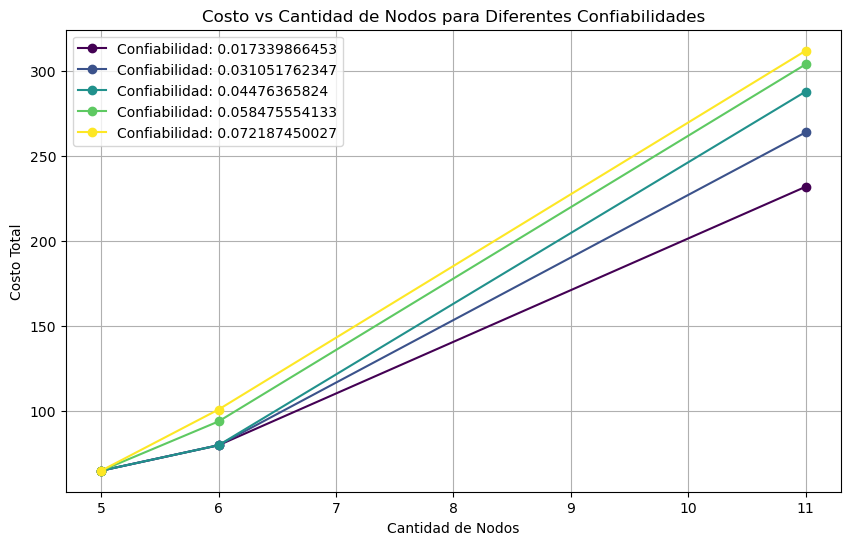

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def grafico_costo_vs_cantidad_nodos_general(costos):
    """
    Genera un gráfico de Costo vs Cantidad de Nodos para una confiabilidad.

    :param costos: Lista de tuplas (nodos, confiabilidad, costo) con los resultados.
    """
    data = pd.DataFrame(costos, columns=['Nodos', 'Confiabilidad', 'Costo'])
    confiabilidades_unicas = sorted(data['Confiabilidad'].unique())
    colores = plt.cm.viridis(np.linspace(0, 1, len(confiabilidades_unicas)))

    plt.figure(figsize=(10, 6))
    for conf, color in zip(confiabilidades_unicas, colores):
        subset = data[data['Confiabilidad'] == conf]
        plt.plot(subset['Nodos'], subset['Costo'], marker='o',
                 linestyle='-', color=color, label=f'Confiabilidad: {conf}')

    plt.title(f"Costo vs Cantidad de Nodos para Diferentes Confiabilidades")
    plt.xlabel("Cantidad de Nodos")
    plt.ylabel("Costo Total")
    plt.grid(True)
    plt.legend()
    plt.show()

costosSerie = [] # Lista para almacenar los costos asociados
tipoNodosSerie = []

seriesMinReliability = reliabilityByNodeType[0] ** 11
seriesMaxReliability = reliabilityByNodeType[2] ** 11
seriesRequiredReliabilities = generate_equidistant_list(seriesMinReliability, seriesMaxReliability, 5)

for nodos in [5,6,11]:

    for confiabilidad in seriesRequiredReliabilities:
        model_base = base_model(nodos, costByNodeType) # Crear modelo base
        minCost, variables, serieModel = serie_model(model_base, nodos, linkCost, reliabilityByNodeType, confiabilidad) # Crear modelo serie

        if variables is None:  # Cuando no hay solución
            print(f"No se encontró solución={nodos} y confiabilidad={confiabilidad}")
            costosSerie.append((nodos, confiabilidad, None))
            tipoNodosSerie.append({'Low': 0, 'Medium': 0, 'High': 0})
            continue

        costosSerie.append((nodos, confiabilidad, minCost))# Almacenar resultados de costos

        # Procesar variables de decisión para obtener tipos de nodo
        tipoNodo = {'Low': 0, 'Medium': 0, 'High': 0}
        for var, value in variables.items():
            if var.startswith("x"):
                _, tipo = map(int, var.split('[')[1].split(']')[0].split(','))
                if tipo == 1:
                    tipoNodo['Low'] += int(value)
                elif tipo == 2:
                    tipoNodo['Medium'] += int(value)
                elif tipo == 3:
                    tipoNodo['High'] += int(value)
        tipoNodosSerie.append(tipoNodo)

grafico_costo_vs_cantidad_nodos_general(costosSerie)

## Paralelo

In [7]:
# Obtener la confiabilidad mínima y máxima obtenibles para el modelo en paralelo
# Hacer una lista de confiabilidades equidistantes entre la mínima y máxima
parallelMinReliability = 1 - ((1 - reliabilityByNodeType[0]) ** totalNodes)
parallelMaxReliability = 1 - ((1 - reliabilityByNodeType[2]) ** totalNodes)
parallelRequiredReliabilities = generate_equidistant_list(parallelMinReliability, parallelMaxReliability, 10)
print(parallelMinReliability, parallelMaxReliability)
print(parallelRequiredReliabilities)

0.9998951424 0.9999998976
[0.9999046656, 0.9999141888, 0.999923712, 0.9999332352, 0.9999427584, 0.9999522816, 0.9999618048, 0.999971328, 0.9999808512, 0.9999903744]


In [8]:
# Crear y optimizar el modelo en paralelo
try:
    parallelMinCost, parallelVars, parallelModel = parallel_model(baseModel, totalNodes, linkCost, reliabilityByNodeType, parallelRequiredReliabilities[5])
    mostrarResultadosTabla(totalNodes, parallelMinCost, parallelVars)
except Exception as e:
    print(f"Error: {e}")

Cantidad de Nodos: 10
Resultado de la Optimización:
Costo Total: 521.0
Costo nodos: 71.0
Costo enlaces: 450.0
Nodos activos (x):
    Low Cost  Mid Cost  High Cost
1          0         1          0
2          1         0          0
3          1         0          0
4          1         0          0
5          1         0          0
6          1         0          0
7          0         1          0
8          0         1          0
9          1         0          0
10         1         0          0


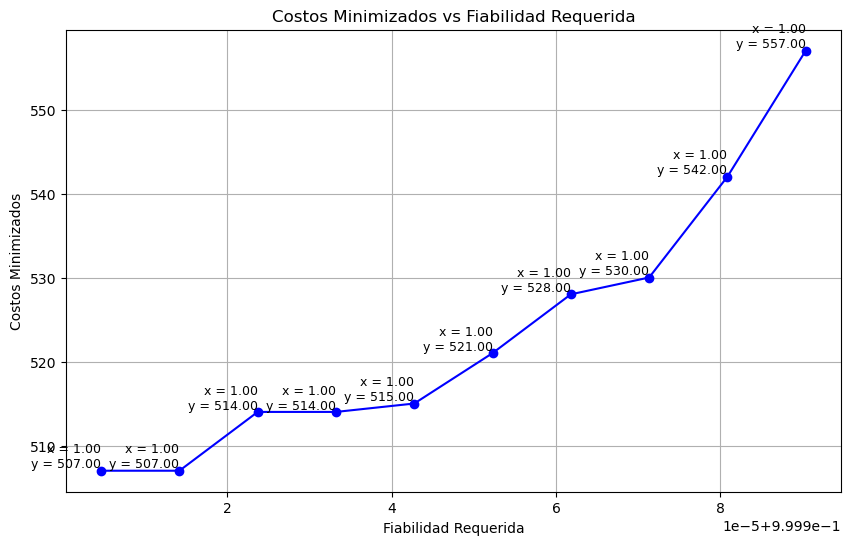

In [9]:
# Graficar los costos minimizados para cada confiabilidad requerida
try:
    parallelMinimizedCosts = []
    for reqReliability in parallelRequiredReliabilities:
        minCost, parallelVars, parallelModel = parallel_model(baseModel, totalNodes, linkCost, reliabilityByNodeType, reqReliability)
        parallelMinimizedCosts.append(minCost)
    graficar_costos_minimizados(parallelRequiredReliabilities, parallelMinimizedCosts)
except ValueError as e:
    print(f"Error: {e}")

## Hibrido

In [13]:
# Obtener la confiabilidad mínima y máxima obtenibles para el modelo hibrido
# Hacer una lista de confiabilidades equidistantes entre la mínima y máxima
hybridMinReliability = (1-((1-reliabilityByNodeType[0])**3))*(reliabilityByNodeType[0]**(totalNodes-3))
hybridMaxReliability = reliabilityByNodeType[2]
hybridRequiredReliabilities = generate_equidistant_list(hybridMinReliability, hybridMaxReliability, 10)
print(hybridMinReliability, hybridMaxReliability)
print(hybridRequiredReliabilities)

0.026202009599999992 0.8
[0.096547281455, 0.166892553309, 0.237237825164, 0.307583097018, 0.377928368873, 0.448273640727, 0.518618912582, 0.588964184436, 0.659309456291, 0.729654728145]


In [17]:
# Crear y optimizar el modelo híbrido
try:
    hybridMinCost, hybridVars, hybridModel = hybrid_model(baseModel, totalNodes, linkCost, reliabilityByNodeType, hybridRequiredReliabilities[9])
    mostrarResultadosTabla(totalNodes, hybridMinCost, hybridVars, "hibrido")
    # for var in hybridVars:
    #     if not var.startswith("x") and not var.startswith("y"):
    #         print(f"Variable {var}: {hybridVars[var]}")
except Exception as e:
    print(f"Error: {e}")

Cantidad de Nodos: 10
Resultado de la Optimización:
Costo Total: 237.0
Costo nodos: 117.0
Costo enlaces: 120.0
Nodos activos (x):
    Low Cost  Mid Cost  High Cost
1          1         0          0
2          1         0          0
3          1         0          0
4          0         0          1
5          1         0          0
6          1         0          0
7          0         0          1
8          0         0          1
9          0         1          0
10         0         0          1
Nodos activos (y):
    Subred 0  Subred 1  Subred 2  Subred 3
1          0         0         1         0
2          0         0         0         1
3          0         1         0         0
4          0         0         0         1
5          0         1         0         0
6          0         0         0         1
7          1         0         0         0
8          0         0         1         0
9          0         0         1         0
10         0         1         0         0


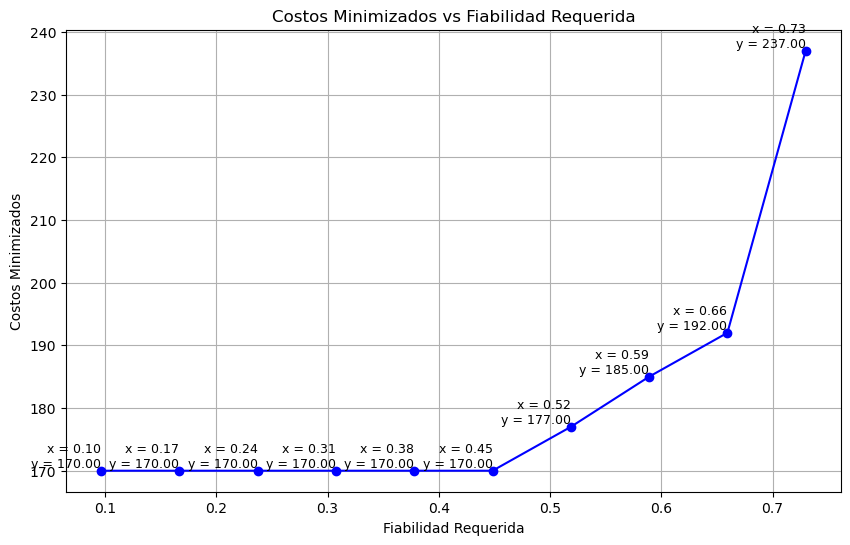

In [16]:
# Graficar los costos minimizados para cada confiabilidad requerida
try:
    hybridMinimizedCosts = []
    for reqReliability in hybridRequiredReliabilities:
        minCost, hybridVars, hybridModel = hybrid_model(baseModel, totalNodes, linkCost, reliabilityByNodeType, reqReliability)
        hybridMinimizedCosts.append(minCost)
    graficar_costos_minimizados(hybridRequiredReliabilities, hybridMinimizedCosts)
except ValueError as e:
    print(f"Error: {e}")